In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400

data_dir = "./DS1"

# test set
train_data_dir = "./DS1/Train"
test_data_dir = "./DS1/Test"
valid_data_dir = "./DS1/Valid"

class_names = os.listdir(train_data_dir)

first_execution = True

if first_execution:
    create_test_set(train_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(train_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

data_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_directory(
        valid_data_dir,
        target_size = (img_height, img_width),
        batch_size = 14,
        class_mode = 'binary',
        shuffle = True
)

Found 302 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [6]:
base_model = EfficientNetB7(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# freeze already trained layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_initializer = 'uniform')(x)
predictions = Dense(1, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 400, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 rescaling (Rescaling)          (None, 80, 400, 3)   0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 80, 400, 3)   7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 80, 400, 3)   0           ['normalization[0][0]']      

 block1c_activation (Activation  (None, 40, 200, 32)  0          ['block1c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_s

                                                                                                  
 block2a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, 20, 100, 192  0           ['block2a_activation[0][0]',     
                                )                                 'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 20, 100, 48)  9216        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 20, 100, 48)  192        ['block2a_project_conv[0][0]']   
 lization)                                                                                        
          

 block2c_project_bn (BatchNorma  (None, 20, 100, 48)  192        ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_drop (Dropout)         (None, 20, 100, 48)  0           ['block2c_project_bn[0][0]']     
                                                                                                  
 block2c_add (Add)              (None, 20, 100, 48)  0           ['block2c_drop[0][0]',           
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 20, 100, 288  13824       ['block2c_add[0][0]']            
                                )                                                                 
          

 block2e_drop (Dropout)         (None, 20, 100, 48)  0           ['block2e_project_bn[0][0]']     
                                                                                                  
 block2e_add (Add)              (None, 20, 100, 48)  0           ['block2e_drop[0][0]',           
                                                                  'block2d_add[0][0]']            
                                                                                                  
 block2f_expand_conv (Conv2D)   (None, 20, 100, 288  13824       ['block2e_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2f_expand_bn (BatchNormal  (None, 20, 100, 288  1152       ['block2f_expand_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                  'block2f_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 20, 100, 288  13824       ['block2g_add[0][0]']            
                                )                                                                 
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 20, 100, 288  1152       ['block3a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block3a_expand_activation (Act  (None, 20, 100, 288  0          ['block3a_expand_bn[0][0]']      
 ivation)                       )                                                                 
          

                                                                                                  
 block3c_expand_activation (Act  (None, 10, 50, 480)  0          ['block3c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 10, 50, 480)  12000      ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_bn (BatchNormalization  (None, 10, 50, 480)  1920       ['block3c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3c_a

 D)                                                              ']                               
                                                                                                  
 block3e_bn (BatchNormalization  (None, 10, 50, 480)  1920       ['block3e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3e_activation (Activation  (None, 10, 50, 480)  0          ['block3e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3e_se_squeeze (GlobalAver  (None, 480)         0           ['block3e_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block3g_activation (Activation  (None, 10, 50, 480)  0          ['block3g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3g_se_squeeze (GlobalAver  (None, 480)         0           ['block3g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3g_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3g_se_squeeze[0][0]']     
                                                                                                  
 block3g_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3g_se_reshape[0][0]']     
                                                                                                  
 block3g_s

                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 5, 25, 960)   0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 5, 25, 160)   153600      ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_p

 block4d_se_excite (Multiply)   (None, 5, 25, 960)   0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 5, 25, 160)   153600      ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 5, 25, 160)  640         ['block4d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4d_drop (Dropout)         (None, 5, 25, 160)   0           ['block4d_project_bn[0][0]']     
                                                                                                  
 block4d_a

 block4f_project_bn (BatchNorma  (None, 5, 25, 160)  640         ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 5, 25, 160)   0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 5, 25, 160)   0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
                                                                                                  
 block4g_expand_conv (Conv2D)   (None, 5, 25, 960)   153600      ['block4f_add[0][0]']            
                                                                                                  
 block4g_e

 block4h_add (Add)              (None, 5, 25, 160)   0           ['block4h_drop[0][0]',           
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 5, 25, 960)   153600      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 5, 25, 960)  3840        ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4i_expand_activation (Act  (None, 5, 25, 960)  0           ['block4i_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block5a_expand_bn (BatchNormal  (None, 5, 25, 960)  3840        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 5, 25, 960)  0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 5, 25, 960)  24000       ['block5a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 5, 25, 960)  3840        ['block5a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 5, 25, 1344)  0          ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_s

 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 5, 25, 1344)  0           ['block5e_activation[0][0]',     
          

 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5g_se_reduce[0][0]']      
                                                                                                  
 block5g_se_excite (Multiply)   (None, 5, 25, 1344)  0           ['block5g_activation[0][0]',     
                                                                  'block5g_se_expand[0][0]']      
                                                                                                  
 block5g_project_conv (Conv2D)  (None, 5, 25, 224)   301056      ['block5g_se_excite[0][0]']      
                                                                                                  
 block5g_project_bn (BatchNorma  (None, 5, 25, 224)  896         ['block5g_project_conv[0][0]']   
 lization)

                                                                  'block5i_se_expand[0][0]']      
                                                                                                  
 block5i_project_conv (Conv2D)  (None, 5, 25, 224)   301056      ['block5i_se_excite[0][0]']      
                                                                                                  
 block5i_project_bn (BatchNorma  (None, 5, 25, 224)  896         ['block5i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5i_drop (Dropout)         (None, 5, 25, 224)   0           ['block5i_project_bn[0][0]']     
                                                                                                  
 block5i_add (Add)              (None, 5, 25, 224)   0           ['block5i_drop[0][0]',           
          

 block6a_project_conv (Conv2D)  (None, 3, 13, 384)   516096      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 3, 13, 384)  1536        ['block6a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 3, 13, 2304)  884736      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 3, 13, 2304)  9216       ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_e

 block6d_expand_conv (Conv2D)   (None, 3, 13, 2304)  884736      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 3, 13, 2304)  9216       ['block6d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6d_expand_activation (Act  (None, 3, 13, 2304)  0          ['block6d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 3, 13, 2304)  57600      ['block6d_expand_activation[0][0]
 D)                                                              ']                               
          

 block6f_expand_activation (Act  (None, 3, 13, 2304)  0          ['block6f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6f_dwconv (DepthwiseConv2  (None, 3, 13, 2304)  57600      ['block6f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6f_bn (BatchNormalization  (None, 3, 13, 2304)  9216       ['block6f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 3, 13, 2304)  0          ['block6f_bn[0][0]']             
 )        

                                                                                                  
 block6h_bn (BatchNormalization  (None, 3, 13, 2304)  9216       ['block6h_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6h_activation (Activation  (None, 3, 13, 2304)  0          ['block6h_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6h_se_squeeze (GlobalAver  (None, 2304)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_s

 )                                                                                                
                                                                                                  
 block6j_se_squeeze (GlobalAver  (None, 2304)        0           ['block6j_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6j_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6j_se_squeeze[0][0]']     
                                                                                                  
 block6j_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6j_se_reduce[0][0]']      
          

 block6l_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6l_se_squeeze[0][0]']     
                                                                                                  
 block6l_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6l_se_reshape[0][0]']     
                                                                                                  
 block6l_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6l_se_reduce[0][0]']      
                                                                                                  
 block6l_se_excite (Multiply)   (None, 3, 13, 2304)  0           ['block6l_activation[0][0]',     
                                                                  'block6l_se_expand[0][0]']      
                                                                                                  
 block6l_project_conv (Conv2D)  (None, 3, 13, 384)   884736      ['block6l_se_excite[0][0]']      
          

                                                                                                  
 block7a_se_excite (Multiply)   (None, 3, 13, 2304)  0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 3, 13, 640)   1474560     ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 3, 13, 640)  2560        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 3, 13, 3840)  2457600     ['block7a_project_bn[0][0]']     
          

                                                                                                  
 block7c_add (Add)              (None, 3, 13, 640)   0           ['block7c_drop[0][0]',           
                                                                  'block7b_add[0][0]']            
                                                                                                  
 block7d_expand_conv (Conv2D)   (None, 3, 13, 3840)  2457600     ['block7c_add[0][0]']            
                                                                                                  
 block7d_expand_bn (BatchNormal  (None, 3, 13, 3840)  15360      ['block7d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7d_expand_activation (Act  (None, 3, 13, 3840)  0          ['block7d_expand_bn[0][0]']      
 ivation) 

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

### Please note that while the loss curve is ideal, the accuracy curve is a clear example of an algorithm that is not learning anything. The fact that neither validation nor training accuracy changes at any point through time is a clear indication that the algorithm isn't really learning anything at all, i.e. the train and validation sets are insufficient for the task

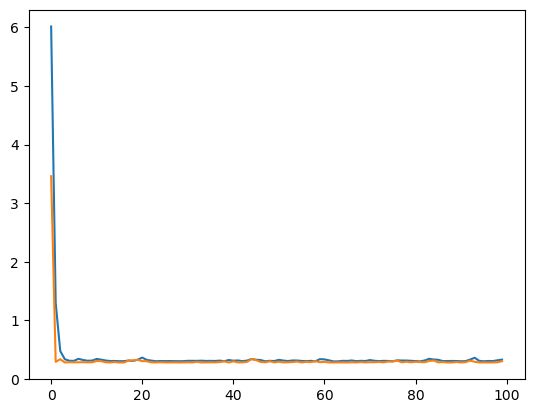

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

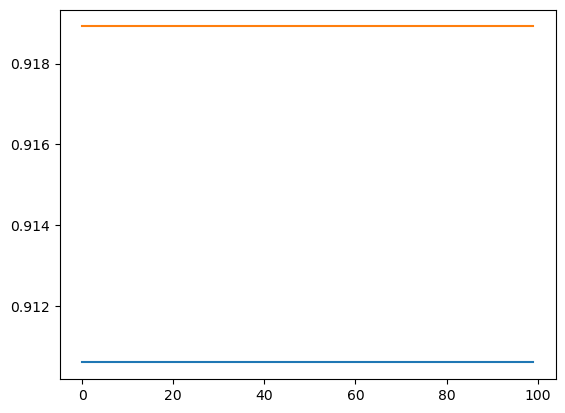

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'binary',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False
)

Found 159 images belonging to 2 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)

### Please note through both loss values and the confusion matrix that the algorithm basically classes everything as a cut mark, regardless of whether it is or it isnt, this is a clear sign of an algorithm that is not working. This is due to the large imbalance between the two classes in the dataset

In [13]:
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
test_croc_probs = 1 - test_probs[indices0]
test_cm_probs = test_probs[indices1]

print(f"Crocodile Loss {np.sqrt(np.mean(np.square(1 - test_croc_probs))) * 100:.2f}%")
print(f"Cut Mark Loss {np.sqrt(np.mean(np.square(1 - test_cm_probs))) * 100:.2f}%")
print(f"Overall Loss {np.sqrt(np.mean(np.square(np.concatenate((1 - test_croc_probs, 1 - test_cm_probs))))) * 100:.2f}%")

Crocodile Loss 100.00%
Cut Mark Loss 0.00%
Overall Loss 28.59%


In [14]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15        13
         1.0       0.00      0.00      0.00       146

    accuracy                           0.08       159
   macro avg       0.04      0.50      0.08       159
weighted avg       0.01      0.08      0.01       159

[[ 13   0]
 [146   0]]


C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [15]:
return_files = True

if return_files:
    source_folders = ["./DS1/Test", "./DS1/Valid"]
    destination_folder = "./DS1/Train"

    for source_folder in source_folders:
        croc_source_path = os.path.join(source_folder, "Crocodile")
        cut_mark_source_path = os.path.join(source_folder, "CutMark")

        croc_destination_path = os.path.join(destination_folder, "Crocodile")
        cut_mark_destination_path = os.path.join(destination_folder, "CutMark")

        for filename in os.listdir(croc_source_path):
            source_file = os.path.join(croc_source_path, filename)
            destination_file = os.path.join(croc_destination_path, filename)
            shutil.move(source_file, destination_file)

        for filename in os.listdir(cut_mark_source_path):
            source_file = os.path.join(cut_mark_source_path, filename)
            destination_file = os.path.join(cut_mark_destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.
